In [57]:
using Pkg
Pkg.activate("../Project.toml")

using ITensors
using Plots
import NDTensors
using Random
using Symbolics
include("summary.jl")
include("utils.jl")

  Activating project at `~/Documents/QML Project/QuantumInspiredML`


loadMPS_tests (generic function with 1 method)

In [2]:
function generate_startingMPS(χ_init, site_indices::Vector{Index{Int64}};
    num_classes = 2, random_state=nothing)
    """Generate the starting weight MPS, W using values sampled from a 
    Gaussian (normal) distribution. Accepts a χ_init parameter which
    specifies the initial (uniform) bond dimension of the MPS."""
    
    if random_state !== nothing
        # use seed if specified
        Random.seed!(random_state)
        println("Generating initial weight MPS with bond dimension χ = $χ_init
        using random state $random_state.")
    else
        println("Generating initial weight MPS with bond dimension χ = $χ_init.")
    end

    W = randomMPS(ComplexF64,site_indices, linkdims=χ_init)

    label_idx = Index(num_classes, "f(x)")

    # get the site of interest and copy over the indices at the last site where we attach the label 
    old_site_idxs = inds(W[end])
    new_site_idxs = old_site_idxs, label_idx
    new_site = randomITensor(new_site_idxs)

    # add the new site back into the MPS
    W[end] = new_site

    # normalise the MPS
    normalize!(W)

    # canonicalise - bring MPS into canonical form by making all tensors 1,...,j-1 left orthogonal
    # here we assume we start at the right most index
    last_site = length(site_indices)
    orthogonalize!(W, last_site)

    return W

end


generate_startingMPS (generic function with 1 method)

In [3]:
random_state=123456
update_iters = 9
χ_init = 4
(X_train, y_train), (X_val, y_val), (X_test, y_test) = load_splits_txt("datasets/ECG_train.txt", 
    "datasets/ECG_val.txt", "datasets/ECG_test.txt")

X_train = vcat(X_train, X_val)
y_train = vcat(y_train, y_val)   
   
# first, create the site indices for the MPS and product states 
num_mps_sites = size(X_train)[2]
sites = siteinds("S=1/2", num_mps_sites)
println("Using χ_init=$χ_init and a maximum of $nsweep sweeps...")
println("Using $update_iters iterations per update.")

# now let's handle the training/validation/testing data
# rescale using a robust sigmoid transform
scaler = fit_scaler(RobustSigmoidTransform, X_train; positive=true);
X_train_scaled = transform_data(scaler, X_train)
X_val_scaled = transform_data(scaler, X_val)
X_test_scaled = transform_data(scaler, X_test)

# generate product states using rescaled data

training_states = generate_all_product_states(X_train_scaled, y_train, "train", sites)
validation_states = generate_all_product_states(X_val_scaled, y_val, "valid", sites)
testing_states = generate_all_product_states(X_test_scaled, y_test, "test", sites)

# generate the starting MPS with unfirom bond dimension χ_init and random values (with seed if provided)
num_classes = length(unique(y_train))
W = generate_startingMPS(χ_init, sites; num_classes=num_classes, random_state=random_state)


    ;

Using χ_init=4 and a maximum of nsweep sweeps...
Using 9 iterations per update.
Initialising train states.
Initialising valid states.
Initialising test states.
Generating initial weight MPS with bond dimension χ = 4
        using random state 123456.


In [9]:
ps = testing_states[1].pstate[4]
psc = conj(testing_states[1].pstate)[4]

ITensor ord=1 (dim=2|id=335|"S=1/2,Site,n=4")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}

In [10]:
@show ps[2]

@show psc[2]

ps[2] = -0.18403182251595995 + 0.9809770924363289im
psc[2] = -0.18403182251595995 - 0.9809770924363289im


-0.18403182251595995 - 0.9809770924363289im

10-element Vector{Float64}:
 0.9152689217213907
 0.050579416129095334
 0.2986122462427898
 0.09606641103497526
 0.17333694851250936
 0.4823231854509712
 0.5956895622685154
 0.5752472124374269
 0.985118852561259
 0.5133432424306262

In [12]:
ts_len=96
xs=0:1/96:1

97-element Vector{Float64}:
 0.0
 0.010416666666666666
 0.020833333333333332
 0.03125
 0.041666666666666664
 0.052083333333333336
 0.0625
 0.07291666666666667
 0.08333333333333333
 0.09375
 ⋮
 0.9166666666666666
 0.9270833333333334
 0.9375
 0.9479166666666666
 0.9583333333333334
 0.96875
 0.9791666666666666
 0.9895833333333334
 1.0

In [30]:
nCr(n,r) = factorial(n) / (factorial(r) * factorial(n-r))

function trigfmap(s,d)
    return x-> sqrt(nCr(d-1,s-1)) *cospi.(x/2).^(d-s) .* sinpi.(x/2).^(s-1)
end


function plotfeaturemap(xs,d)
    ys = trigfmap(1,d)
    plot(xs,ys(xs))
    for s = 2:d
        ys = trigfmap(s,d)
        plot!(xs,ys(xs))
    end
end

plotfeaturemap (generic function with 1 method)

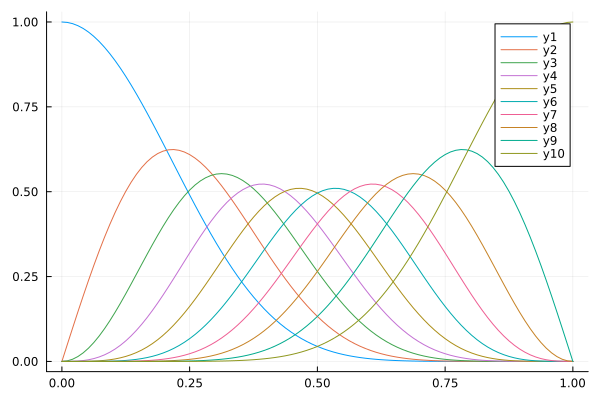

In [46]:
d=10
ys = trigfmap(1,d)
p = plot(xs,ys(xs))
for s = 2:d
    ys = trigfmap(s,d)
    plot!(xs,ys(xs))
end
p

In [44]:
abstract type trigpow end

mutable struct cospow <: trigpow
    pow::Int
end

mutable struct sinpow <: trigpow
    pow :: Int
end

redpow!(tp::trigpow) = tp.pow -= 1




In [55]:
struct trigFT_te
    sinpow::Int
    cospow::Int
end 

dec_sin!(t::trigFT_te) = trigFT_te.sinpow -= 1
dec_cos!(t::trigFT_te) = trigFT_te.cospow -= 1

dec_cos! (generic function with 1 method)

In [58]:
@variables w d(w)
function integrate(tFT::trigFT_te, angle::Real;delta=d)
    if tFT.sinpow != 0
        out = (integrate(dec_sin!(tFt, angle - 1/4)) - integrate(dec_sin!(tFt, angle + 1/4)))/2im
    elseif tFT.cospow !=0
        out = (integrate(dec_cos!(tFt, angle - 1/4)) + integrate(dec_cos!(tFt, angle + 1/4)))/2
    else
        out = d(angle)
    end
    return out
end


LoadError: LoadError: UndefVarError: `@symbolics` not defined
in expression starting at /home/noodles/Documents/QML Project/QuantumInspiredML/LogLoss/test_save.ipynb:1

In [52]:
x = 2

x -= 1


1

In [54]:
2im

0 + 2im